## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

### Установка BigARTM
Все точно как в инструкции на их сайте, только без установки питона и пипа.

In [0]:
!apt-get --yes install git make cmake build-essential libboost-all-dev

In [2]:
!pip install protobuf tqdm wheel

In [3]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

Cloning into 'bigartm'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 15998 (delta 14), reused 9 (delta 3), pack-reused 15953
Receiving objects: 100% (15998/15998), 16.99 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (11147/11147), done.


In [4]:
cd bigartm

/content/bigartm


In [0]:
mkdir build

In [6]:
cd build

/content/bigartm/build


In [0]:
!cmake ..

In [0]:
!make

In [9]:

!pip install python/bigartm*.whl -U

Processing ./python/bigartm-0.9.0-cp36-cp36m-linux_x86_64.whl


Вернемся в изначальную папку.

In [10]:
cd ../.. 

/content


In [0]:
!pip install pymorphy2[fast] nltk gensim

In [12]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalpha()] #только слова, без цифр
    return clean

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Возьмем теже данные

In [0]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/habr_texts.txt.zip

In [16]:
!unzip habr_texts.txt.zip

Archive:  habr_texts.txt.zip
  inflating: habr_texts.txt          


In [0]:
habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt')]

In [0]:
# вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                          common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
p = gensim.models.phrases.Phraser(ph)
texts = p[habr_texts]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [0]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [0]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [0]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [44]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=0437c059-c721-4b63-93e9-b070347526c9, num_entries=18824)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [0]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [0]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [0]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [0]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [0]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4367.815 (ARTM)


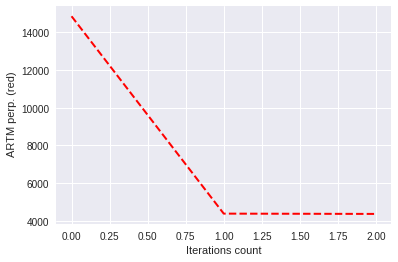

In [29]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [0]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.787 ARTM)
Sparsity Theta: 0.090 (ARTM)
Kernel contrast: 0.266 (ARTM)
Kernel purity: 0.234 (ARTM)
Perplexity: 2136.518 (ARTM)


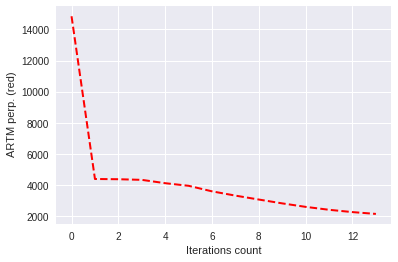

In [33]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [0]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

In [0]:
def ntopics():
    for i in [20, 50, 100, 200, 500]:
        model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(i)],

                           regularizers=[
                               artm.DecorrelatorPhiRegularizer(
                                                name='Decorr', tau=0.25, 
                                                class_ids=['@default_class'],
                                                topic_names=['topic_{}'.format(i) for i in range(0, i)]),

                               artm.SmoothSparsePhiRegularizer(
                                                name='SmoothPhi_1', 
                                                class_ids=['@default_class'],
                                                tau=0.15, 
                                                topic_names=['topic_{}'.format(i) for i in range(0, i)])
                                        ]
                            )
        model_artm.initialize(dictionary=dictionary, )

        model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                            dictionary=dictionary))
        model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
        model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
        model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
        model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

        model_artm.num_document_passes = 2
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
        print (i)
        print_measures(model_artm)

20
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.116 (ARTM)
Kernel purity: 0.118 (ARTM)
Perplexity: 5096.045 (ARTM)


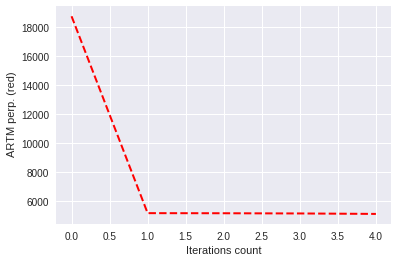

50
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.040 (ARTM)
Kernel purity: 0.003 (ARTM)
Perplexity: 5116.341 (ARTM)


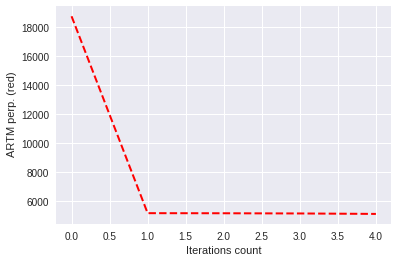

100
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.021 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 5178.619 (ARTM)


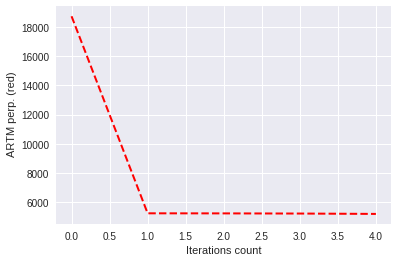

200
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.006 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 5329.729 (ARTM)


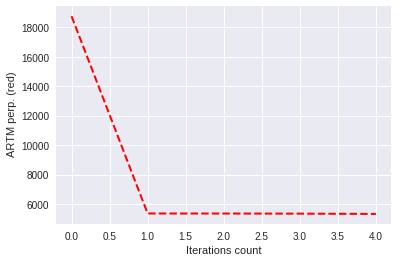

500
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5838.728 (ARTM)


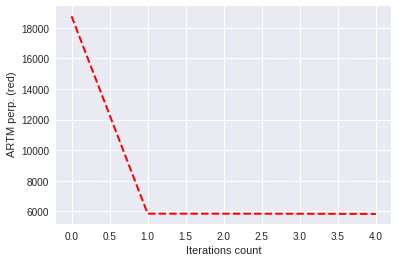

In [48]:
ntopics()

In [0]:
def tau():
    i = 50 #возьмем 50 тем
    for t in [0.01, 0.1, 0.25, 0.5, 1]:
        model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(i)],

                           regularizers=[
                               artm.DecorrelatorPhiRegularizer(
                                                name='Decorr', tau=t, 
                                                class_ids=['@default_class'],
                                                topic_names=['topic_{}'.format(i) for i in range(0, i)]),

                               artm.SmoothSparsePhiRegularizer(
                                                name='SmoothPhi_1', 
                                                class_ids=['@default_class'],
                                                tau=t, 
                                                topic_names=['topic_{}'.format(i) for i in range(0, i)])
                                        ]
                            )
        model_artm.initialize(dictionary=dictionary, )

        model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                            dictionary=dictionary))
        model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
        model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
        model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
        model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

        model_artm.num_document_passes = 2
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
        print (t)
        print_measures(model_artm)

0.01
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.094 (ARTM)
Kernel purity: 0.005 (ARTM)
Perplexity: 5074.576 (ARTM)


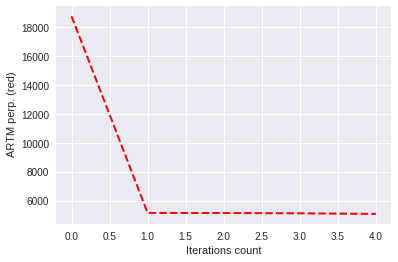

0.1
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.046 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 5099.287 (ARTM)


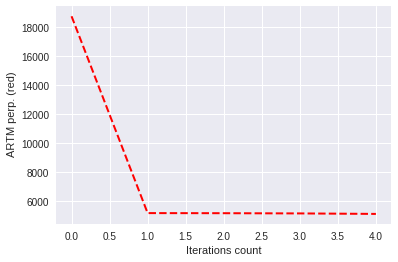

0.25
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.038 (ARTM)
Kernel purity: 0.003 (ARTM)
Perplexity: 5155.968 (ARTM)


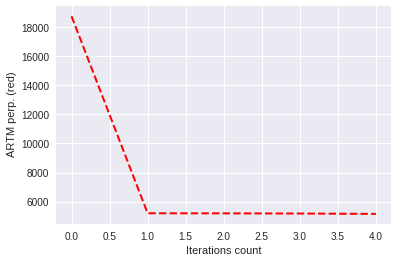

0.5
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.042 (ARTM)
Kernel purity: 0.002 (ARTM)
Perplexity: 5275.621 (ARTM)


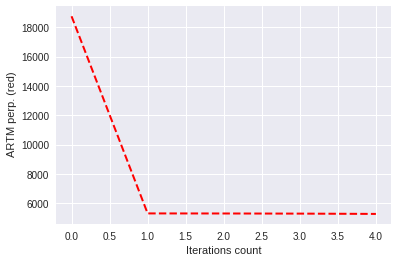

1
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.030 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 5551.354 (ARTM)


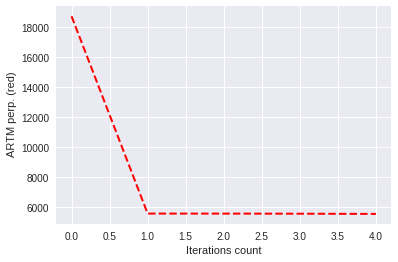

In [55]:
tau()

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.094 (ARTM)
Kernel purity: 0.005 (ARTM)
Perplexity: 5074.575 (ARTM)


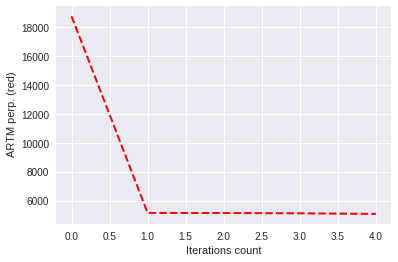

In [60]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.01, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 50)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.01, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 50)])
                                    ]
                        )

model_artm.initialize(dictionary=dictionary, )

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                        dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 
    
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
print_measures(model_artm)

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2, #больше
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 50)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.2, #больше
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 50)]))


model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.918 ARTM)
Sparsity Theta: 0.058 (ARTM)
Kernel contrast: 0.456 (ARTM)
Kernel purity: 0.783 (ARTM)
Perplexity: 2843.995 (ARTM)


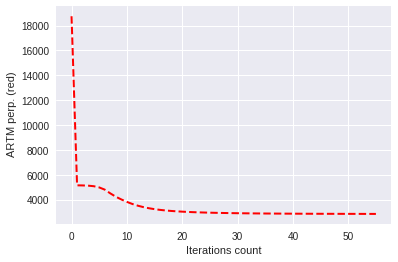

In [62]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(25): #посмотрим дальше
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=2)
    
    
print_measures(model_artm)

In [65]:
# посмотрим на темы
for topic_name in np.array(model_artm.topic_names)[[0,1,3]]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
мозг
изменение
образ
происходить
клетка
состояние
активность
информация
механизм
между
---------
topic_1: 
безопасность
защита
атака
компьютер
уязвимость
проблема
известный
под
microsoft
злоумышленник
---------
topic_3: 
страна
российский
организация
являться
информация
россия
закон
сша
открытый
принять
---------


1. Оставлены только слова, без цифр
1. Добавлены фразы
2. Количество тем выбрано 50 (по итогам экспериментов)
3. Изменено тау - оказалось, что с маленьким результаты лучше
4. В итоге ядра более выделимые, больше контраст между темами
5. Темы хорошо интерпретируемые
6. Фи и тета при подкрутке сделаны больше, в итоге до 20 итераций снижается сильно, потом до 40 плавно, дальше примерно прямая